In [312]:
#Import all libraries

import pandas as pd
import numpy as np
import chardet
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller

from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, classification_report, roc_auc_score

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics.pairwise import pairwise_distances

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import joblib


## Loading of data

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
ratings_orig = pd.read_csv('sample30.csv')
data_desc = pd.read_csv('Data+Attribute+Description.csv')

## Data Cleaning

In [4]:
ratings = ratings_orig.copy()

In [5]:
ratings.shape

(30000, 15)

In [6]:
ratings.head(3)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive


In [7]:
data_desc

,Attribute,Attribute Description
0,id,Uniques identity number to identify each unique review given by the user to a particular product in the dataset
1,brand,Name of the brand of the product to which user has given review and rating
2,categories,"Category of the product like household essentials, books, personal care products, medicines, cosmetic�items, beauty products, electrical appliances, kitchen and dining products, health care products and many more."
3,manufacturer,Name of the manufacturer of the product
4,name,Name of the product to which user has added review or rating
5,reviews_date,Date on which the review has been added by the user
6,reviews_didPurchase,Whether a particular user has purchased the product or not
7,reviews_doRecommend,Whether a particular user has recommended the product or not
8,reviews_rating,Rating given by the user to a particular product
9,reviews_text,Review given by the user to a particular product


In [8]:
ratings.shape

(30000, 15)

In [9]:
ratings.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

reviews_userCity and reviews_userProvince have more than 93% null values. No amount of imputation would help here and we would not like to add any imaginary data. User city and province does not influence the sentiment classification nor the recommendation system so it is safe to remove them. 

In [10]:
ratings = ratings.drop(['reviews_userCity', 'reviews_userProvince'], axis=1)

Now, checking again for the null values - 

In [11]:
round(((ratings.isnull().sum()/ratings.shape[0])*100),2)

id                      0.00
brand                   0.00
categories              0.00
manufacturer            0.47
name                    0.00
reviews_date            0.15
reviews_didPurchase    46.89
reviews_doRecommend     8.57
reviews_rating          0.00
reviews_text            0.00
reviews_title           0.63
reviews_username        0.21
user_sentiment          0.00
dtype: float64

Removing the column for reviews_didPurchase as well. The values cannot be imputed as there are close to 50% values which are null. 

In [12]:
ratings = ratings.drop(['reviews_didPurchase'], axis=1)

Checking null values again - 

In [13]:
ratings.isnull().sum(axis=0)

id                        0
brand                     0
categories                0
manufacturer            141
name                      0
reviews_date             46
reviews_doRecommend    2570
reviews_rating            0
reviews_text              0
reviews_title           190
reviews_username         63
user_sentiment            1
dtype: int64

In [14]:
round(((ratings.isnull().sum()/ratings.shape[0])*100),2)

id                     0.00
brand                  0.00
categories             0.00
manufacturer           0.47
name                   0.00
reviews_date           0.15
reviews_doRecommend    8.57
reviews_rating         0.00
reviews_text           0.00
reviews_title          0.63
reviews_username       0.21
user_sentiment         0.00
dtype: float64

There is one row for user_sentiment, which has a null value. Let's check that row - 

In [15]:
ratings[ratings['user_sentiment'].isnull()]['reviews_text']

28354    my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy
Name: reviews_text, dtype: object

It looks like the user likes the product and has recommended the product. The review text also shows that the user loved this product and has given it the highest rating. We can make the sentiment for this user as positive. It is safe to classify the review/sentiment as a positive one.

In [16]:
ratings.loc[ratings['user_sentiment'].isnull(),'user_sentiment'] = 'Positive'

In [17]:
ratings.isnull().sum(axis=0)

id                        0
brand                     0
categories                0
manufacturer            141
name                      0
reviews_date             46
reviews_doRecommend    2570
reviews_rating            0
reviews_text              0
reviews_title           190
reviews_username         63
user_sentiment            0
dtype: int64

We can remove the column reviews_date as it is not important for the sentiment classfier or the recommendation system.

In [18]:
ratings = ratings.drop(['reviews_date'], axis=1)

In [19]:
ratings.isnull().sum(axis=0)

id                        0
brand                     0
categories                0
manufacturer            141
name                      0
reviews_doRecommend    2570
reviews_rating            0
reviews_text              0
reviews_title           190
reviews_username         63
user_sentiment            0
dtype: int64

Let's look at the null values for manufacturer and its brands - 

In [20]:
ratings[ratings['manufacturer'].isnull()]['brand'].value_counts()

Summit Entertainment    141
Name: brand, dtype: int64

So for all 141 null values for manufacturer column, the brand is the same - Summit Entertainment. Let's check what is the manufacturer of Summit entertainment brand if there are more rows for the same - 

In [21]:
ratings[ratings['brand'] == 'Summit Entertainment']['manufacturer'].value_counts()

Summit Entertainment    672
Name: manufacturer, dtype: int64

So for all other Summit Entertainment brands, the manufacturer seems to be Summit Entertainment itself. It is unlikely that the brand is the same and the manufacturer is different. It is possible to have different brands under the same manufacturer but not the same brand under different manufacturers. So it is safe to fill in all the manufacturer null values to Summit Entertainment. 

In [22]:
ratings.loc[ratings['manufacturer'].isnull(), 'manufacturer'] = 'Summit Entertainment'

In [23]:
ratings.isnull().sum()

id                        0
brand                     0
categories                0
manufacturer              0
name                      0
reviews_doRecommend    2570
reviews_rating            0
reviews_text              0
reviews_title           190
reviews_username         63
user_sentiment            0
dtype: int64

Username column obviously cannot be removed as we need to make recommendations for them. But if we do not know which user made the review, we cannot impute it with some random name. So it is better to delete the rows that do not have a username. 

In [24]:
ratings = ratings[~ratings['reviews_username'].isnull()]

In [25]:
ratings.isnull().sum()

id                        0
brand                     0
categories                0
manufacturer              0
name                      0
reviews_doRecommend    2541
reviews_rating            0
reviews_text              0
reviews_title           189
reviews_username          0
user_sentiment            0
dtype: int64

There are 189 rows that do not have a review title. We cannot impute or fill it with some text nor is it safe to remove the column entirely as it could be useful in sentiment prediction. So better to delete the rows that have null title. 

In [26]:
ratings = ratings[~ratings['reviews_title'].isnull()]

In [27]:
ratings.isnull().sum()

id                        0
brand                     0
categories                0
manufacturer              0
name                      0
reviews_doRecommend    2376
reviews_rating            0
reviews_text              0
reviews_title             0
reviews_username          0
user_sentiment            0
dtype: int64

In [28]:
ratings.shape

(29748, 11)

We can drop the column reviews_doRecommend since it gives similar information as reviews_text and reviews_rating columns. If the user likes the product and rates it high, he will recommend it and vice versa. So this can be dropped without much info loss.

In [29]:
ratings = ratings.drop(['reviews_doRecommend'], axis=1)

Let's check null values again - 

In [30]:
ratings.isnull().sum()

id                  0
brand               0
categories          0
manufacturer        0
name                0
reviews_rating      0
reviews_text        0
reviews_title       0
reviews_username    0
user_sentiment      0
dtype: int64

In [31]:
ratings.shape

(29748, 10)

Let's see if there are any duplicate rows - 

In [32]:
ratings[ratings.duplicated()].shape

(279, 10)

So there are 279 data items that have duplicate entries. These should be removed - 

In [33]:
ratings = ratings[~(ratings.duplicated())]

In [34]:
ratings.shape

(29469, 10)

In [35]:
ratings.isnull().sum()

id                  0
brand               0
categories          0
manufacturer        0
name                0
reviews_rating      0
reviews_text        0
reviews_title       0
reviews_username    0
user_sentiment      0
dtype: int64

So now we have a clean dataset with no null values and duplicate rows. 

In [36]:
percent_loss = ((ratings_orig.shape[0]-ratings.shape[0])/ratings_orig.shape[0])*100
percent_loss

1.77

There's very little 1.7% data loss after cleaning which is good enough.

Let's check if all the columns are of the right datatype before proceeding further in data analysis - 

In [37]:
ratings.dtypes

id                  object
brand               object
categories          object
manufacturer        object
name                object
reviews_rating       int64
reviews_text        object
reviews_title       object
reviews_username    object
user_sentiment      object
dtype: object

All except the ratings are strings/objects which is good. Also the rating is int type which is correct. 

Let's also make sure there are no spelling mistakes in the brands/manufacturers - 

In [38]:
ratings['brand'].unique()

array(['Universal Music', 'Lundberg', 'K-Y', 'J.R. Watkins', 'AMBI',
       "Johnson's", 'Olay', 'Windex', 'Heinz', 'KIND', 'Pantene',
       'Aussie', 'Disney', 'CeraVe', 'Solo Foods', 'Finish',
       'Jake And The Neverland Pirates', 'Pearhead', 'No Brand',
       'Neutrogena', 'Meguiars', 'Banana Boat', 'Cetaphil', 'Suave',
       'Bumble Bee', 'Citrus Magic', 'La Tortilla Factory',
       'Target.com Use Only', 'Sea Gull Lighting', 'The Seaweed Bath Co.',
       'Way Basics', 'Biokleen', 'Yes to Carrots', 'Alberto VO5',
       'Warner Bros.', 'FOX', 'Progresso', "Herr's", 'Hawaiian Punch',
       'Universal Home Video', 'Holmes', 'Sony Music', "Nature's Path",
       'Lite Source', 'SLOAN VALVE COMPANY', 'Nearly Natural',
       'Toy Story', 'MaraNatha', 'Chex', 'TRESemme', 'Wagan',
       'Creme Of Nature', 'Arrid', 'Eagle Brand', 'Pinaud',
       'Hortense B. Hewitt', 'Canada Dry', 'Baxter of California', 'Ragu',
       'Sabra', 'Pendaflex', "Newman's Own Organics",
       'The 

In [39]:
ratings['manufacturer'].unique()

array(['Universal Music Group / Cash Money', 'Lundberg', 'K-Y',
       'J.R. Watkins', 'FLEMING & CO', "Johnson's", 'P&G', 'Windex',
       'Heinz North America', 'Kind Fruit & Nut Bars', 'Pantene',
       'Aussie', 'Disney/Pixar', 'CeraVe', 'Solo', 'Reckitt Benckiser',
       'Disney', 'Pearhead', '120', 'Johnson & Johnson SLC', 'Parts',
       'Energizer Personal Care', 'Cetaphil', 'UNILEVER', 'Bumble Bee',
       'Citrus Magic', 'La Tortilla Fac', 'Xenon', 'Sea Gull Lighting',
       'The Seaweed Bath', 'Way Basics', 'Biokleen Cleaners',
       'Yes To Inc.', 'High Ridge Brands Co.', 'TIME WARNER',
       'MGM (Video & DVD)', 'Twentieth Century Fox',
       'GENERAL MILLS SALES, INC.', "Herr's", 'Dr Pepper/Seven Up, Inc',
       'Universal', 'UNIVERSAL HOME ENTERTAINMENT',
       'Jarden Home Environment', 'Columbia', 'Pantene Pro-V Hair Care',
       "Nature's Path Foods, Inc.", 'Lite-Source', 'William H Harvey',
       'Nearly Natural', 'Disguise', 'Maranatha Natural Foods',
     

In [40]:
ratings['name'].unique()

array(['Pink Friday: Roman Reloaded Re-Up (w/dvd)',
       'Lundberg Organic Cinnamon Toast Rice Cakes',
       'K-Y Love Sensuality Pleasure Gel',
       'J.R. Watkins Hand Cream, Lemon Cream',
       'Ambi Complexion Cleansing Bar',
       "Johnson's Baby Bubble Bath and Wash, 15oz",
       'Olay Regenerist Deep Hydration Regenerating Cream',
       'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)',
       'Heinz Tomato Ketchup, 38oz',
       'Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count',
       'Pantene Color Preserve Volume Shampoo, 25.4oz',
       'Aussie Aussome Volume Shampoo, 13.5 Oz',
       "Cars Toon: Mater's Tall Tales", 'CeraVe SA Renewing Cream',
       'Solo Foods Almond Paste',
       'Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count',
       'Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler',
       'Pearhead Id Bracelet Frame',
       'Craft Punch Giga Scallop Circle 45 24687534 To 334',
       'Neutrogena

There seems to be a product name - "L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz"] which is basically a L'oreal product but not named correctly. Let's correct all products with this faulty name - 

In [41]:
def extract(string):
    pattern = "^L'or[0-9]+al"
    if(re.search(pattern, string)):
        return string
    else:
        return False

In [42]:
ratings[ratings['name'] == ratings['name'].apply(lambda x:extract(x))]['name']

28814    L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz
28815    L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz
28816    L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz
28817    L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz
28818    L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz
                                              ...                                      
29995    L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz
29996    L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz
29997    L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz
29998    L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz
29999    L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz
Name: name, Length: 1118, dtype:

So there are 1118 rows which are faulty. Let's correct them - 

In [43]:
ratings.loc[ratings['name'] == ratings['name'].apply(lambda x:extract(x)),'name'] = ratings.loc[ratings['name'] == ratings['name'].apply(lambda x:extract(x)),'name'].str.replace('^L\'or[0-9]+al', 'L\'oreal') 

<ipython-input-43-7f4b5f370bef>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  ratings.loc[ratings['name'] == ratings['name'].apply(lambda x:extract(x)),'name'] = ratings.loc[ratings['name'] == ratings['name'].apply(lambda x:extract(x)),'name'].str.replace('^L\'or[0-9]+al', 'L\'oreal')


Now let's make sure the changes have been made - 

In [44]:
ratings[ratings['name'] == ratings['name'].apply(lambda x:extract(x))]['name']

Series([], Name: name, dtype: object)

There is no faulty name anymore. 

Now that the data is clean, spell corrected let's do some EDA

## Exploratory Data Analysis

In [45]:
ratings.shape

(29469, 10)

In [46]:
ratings.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_username', 'user_sentiment'],
      dtype='object')

In [47]:
def data_info(x):
    print(ratings[x].value_counts())
    ratings[x].value_counts().plot(kind='bar')        

Stats for column : id
AVpf3VOfilAPnD_xjpun    8396
AVpfPaoqLJeJML435Xk9    3324
AVpfJP1C1cnluZ0-e3Xy    2022
AVpfRTh1ilAPnD_xYic2    1140
AVpfW8y_LJeJML437ySW    1118
                        ... 
AVpfKa3uilAPnD_xWSGx       1
AVpfP-rELJeJML435jEN       1
AV2Avn5dGV-KLJ3alTjq       1
AVpe-MCY1cnluZ0-bCv_       1
AV1YnUMYglJLPUi8IJpK       1
Name: id, Length: 252, dtype: int64


Stats for column : brand
Clorox               10419
Warner Home Video     3324
Disney                1197
L'oreal Paris         1118
FOX                    887
                     ...  
Udi's                    1
Pearhead                 1
Kenroy Home              1
Scotty                   1
LDR                      1
Name: brand, Length: 199, dtype: int64


Stats for column : categories
Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox



Stats for column : reviews_title
Great Product                   369
Great movie                     361
Clorox Wipes                    269
Great                           216
Great product                   205
                               ... 
GREAT for Families on the Go      1
Disinfects Everything             1
awesome album                     1
Wrong for me                      1
Shampoo Is the Best               1
Name: reviews_title, Length: 18490, dtype: int64


Stats for column : reviews_username
byamazon customer    41
mike                 41
chris                31
sandy                15
rick                 15
                     ..
tallen                1
cleanse               1
spam0ni               1
agard617              1
am2lady               1
Name: reviews_username, Length: 24788, dtype: int64


Stats for column : user_sentiment
Positive    26163
Negative     3306
Name: user_sentiment, dtype: int64




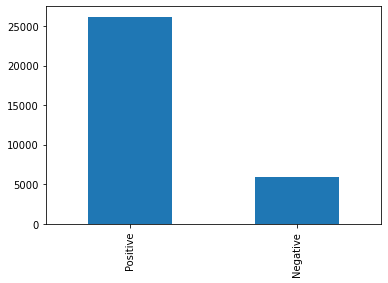

In [48]:
for col in ratings.columns:
    print("Stats for column : "+col )
    data_info(col)
    print("\n")

It can be seen from the above stats, that Clorox is the most reviewed (and probably most bought) brand with 10419 reviews. Since Colorox is more of a household essentials brand, that specific category is the topmost. Obviously even the top most reviewed manufacturer is also Clorox and the top most reviewed product is the Clorox Disinfecting wipes which belongs to the Clorox brand. 

Most of the ratings are 5 i.e out of 29469 records, 20495 records are rated 5 i.e ~70%. Most of the reviews are made by a user names - Mike. 

Coming to the most important aspect - the user sentiment. 26163 records have positive sentiment out of the 29469 total records which is almost 89%. So this is a skewed/imbalanced dataset. 

Let's look at the top most reviewed products, brands, manufacturers to understand how their rating is distributed - 

In [49]:
top_5_products = ratings['name'].value_counts().sort_values(ascending=False)[:5]
top_5_products

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                       8396
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                 3324
Clorox Disinfecting Bathroom Cleaner                                            2022
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)             1140
L'oreal Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz    1118
Name: name, dtype: int64

In [50]:
top_products_df = ratings[ratings['name'].isin(top_5_products.index.tolist())]
top_products_df.head(1)

,id,brand,categories,manufacturer,name,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
6479,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Cleaning & Janitorial Supplies,Cleaners & Disinfectants,Cleaning Wipes & Pads,Cleaning Solutions,Housewares,Target Restock,Food & Grocery,Paper Goods,Wipes,All Purpose Cleaners",Clorox,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,1,"This is an outstanding product, it not only cleans surfaces, but it has such a clean and fresh smell..I use it all the time.",Fresh Smell,barsea,Positive


Text(0.5, 1.0, 'Distribution of ratings in products')

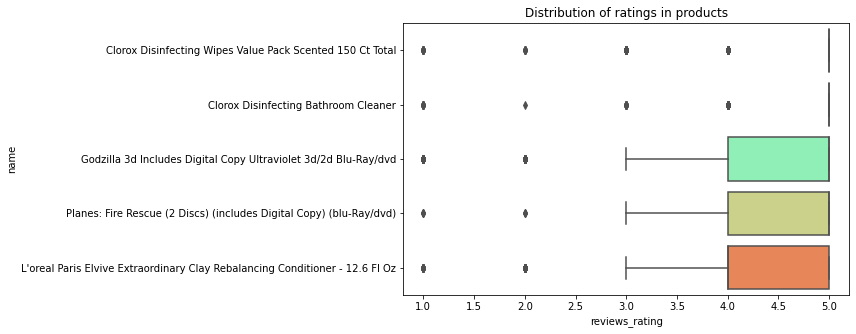

In [51]:
plt.figure(figsize=(8,5))
sns.boxplot(x='reviews_rating',y='name',data=top_products_df, palette='rainbow')
plt.title("Distribution of ratings in products")

So for the top 5 products, most of the ratings are between 4 and 5. i.e they are good products. 

Similarly let's get the distribution of ratings for top 5 most reviewed brands and manufacturers also - 

In [52]:
top_5_brands = ratings['name'].value_counts().sort_values(ascending=False)[:5]
top_5_brands

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                       8396
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                 3324
Clorox Disinfecting Bathroom Cleaner                                            2022
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)             1140
L'oreal Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz    1118
Name: name, dtype: int64

In [53]:
top_brands_df = ratings[ratings['name'].isin(top_5_products.index.tolist())]
top_brands_df.head(1)

,id,brand,categories,manufacturer,name,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
6479,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Cleaning & Janitorial Supplies,Cleaners & Disinfectants,Cleaning Wipes & Pads,Cleaning Solutions,Housewares,Target Restock,Food & Grocery,Paper Goods,Wipes,All Purpose Cleaners",Clorox,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,1,"This is an outstanding product, it not only cleans surfaces, but it has such a clean and fresh smell..I use it all the time.",Fresh Smell,barsea,Positive


Text(0.5, 1.0, 'Distribution of ratings in products')

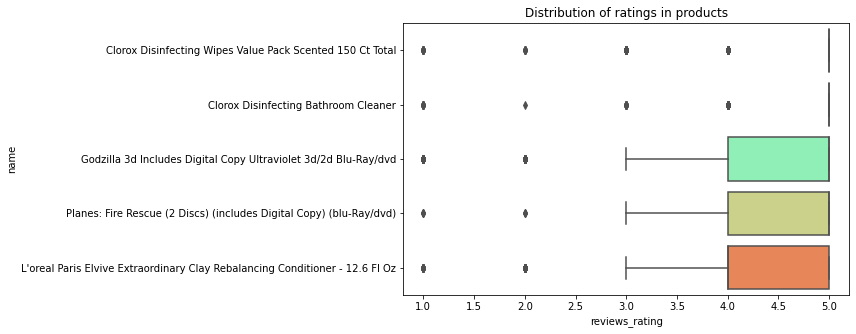

In [54]:
plt.figure(figsize=(8,5))
sns.boxplot(x='reviews_rating',y='name',data=top_brands_df, palette='rainbow')
plt.title("Distribution of ratings in products")

It is the same behaviour as the products. 

Let's look at the user sentiment with these products and brands -

In [55]:
top_products_df.groupby('name')['user_sentiment'].value_counts().sort_values(ascending=False)

name                                                                          user_sentiment
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                     Positive          7593
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd               Positive          3033
Clorox Disinfecting Bathroom Cleaner                                          Positive          1862
L'oreal Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz  Positive          1083
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)           Positive          1060
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                     Negative           803
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd               Negative           291
Clorox Disinfecting Bathroom Cleaner                                          Negative           160
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)           Negative            8

So we can see that the Clorox disinfecting wipes which got the max reviews also has the max positive reviews meaning that's a good product. 

Let's look at the unique number of products and users - 

In [56]:
len(ratings['name'].unique())

252

There are 252 unique products

In [57]:
len(ratings['reviews_username'].unique())

24788

There are 24788 unique users. So if go with user-user recommendation system, the correlation matrix is going to be huge. in this case item-item similarity is better since the number of products are fewer. 

Let's look at the user who gave the max reviews to the products - 

In [58]:
ratings['reviews_username'].value_counts().sort_values(ascending=False)

byamazon customer    41
mike                 41
chris                31
sandy                15
rick                 15
                     ..
nicnach               1
badback35             1
dustinw               1
cgl001                1
am2lady               1
Name: reviews_username, Length: 24788, dtype: int64

Now after some EDA let's look at building the recommendation system.

## Recommendation System (item-item)

Dividing the dataset into train and test - 

In [59]:
# Let's just make a copy of ratings df so that we dont make any unnecessary changes in the final cleaned dataframe
ratings_reco = ratings.copy()
ratings_reco = ratings_reco[['name', 'reviews_username', 'reviews_rating']]
ratings_reco.head()

,name,reviews_username,reviews_rating
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
2,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,K-Y Love Sensuality Pleasure Gel,walker557,1


In [60]:
ratings_reco.isnull().sum()

name                0
reviews_username    0
reviews_rating      0
dtype: int64

In [61]:
# Test and Train split of the dataset.
train, test = train_test_split(ratings_reco, test_size=0.30, random_state=31)

In [320]:
print(train.shape)
print(test.shape)

(20628, 3)
(8841, 3)


In [321]:
joblib.dump(train, 'model/train') 

['model/train']

In [63]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).T
df_pivot.head()

reviews_username,00dog3,00sab00,01impala,02dakota,0325home,06stidriver,08dallas,09mommy11,1.11E+24,11111111aaaaaaaaaaaaaaaaa,...,zpalma,zsarah,zsazsa,zt313,zubb,zulaa118,zuttle,zxjki,zyiah4,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
df_pivot.shape

(238, 18052)

In [65]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_pivot.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.00260653 0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.00260653 0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [66]:
item_correlation.shape

(238, 238)

Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [67]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.00260653, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00260653, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

### Prediction item-item

In [68]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01104884, 0.        , ..., 0.01389017, 0.01636499,
        0.02076641],
       [0.        , 0.06770874, 0.        , ..., 0.03974833, 0.        ,
        0.01304348],
       ...,
       [0.        , 0.00316403, 0.        , ..., 0.00594003, 0.        ,
        0.        ],
       [0.        , 0.00791008, 0.        , ..., 0.01485008, 0.        ,
        0.        ],
       [0.        , 0.00632807, 0.        , ..., 0.01188006, 0.        ,
        0.        ]])

In [69]:
item_predicted_ratings.shape

(18052, 238)

In [70]:
dummy_train = (df_pivot.fillna(0)==0).astype(int)
dummy_train = dummy_train.T
dummy_train.shape

(18052, 238)

In [71]:
dummy_train

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
00sab00,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
01impala,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
02dakota,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0325home,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zulaa118,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
zuttle,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
zxjki,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [72]:
df_pivot.T.loc['zubb'][df_pivot.T.loc['zubb']>1]

name
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)    4.0
Name: zubb, dtype: float64

In [309]:
dummy_train.loc['zubb'].sum()

237

In [310]:
dummy_train.loc['zubb','Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)']

0

It's verified that the places where ratings are given are zeroed in dummy_train df.

In [74]:
dummy_train.shape

(18052, 238)

In [75]:
dummy_train.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
00sab00,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
01impala,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
02dakota,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0325home,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


#### Filtering the rating only for the movies not rated by the user for recommendation

In [304]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091855,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
00sab00,0.0,0.011049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036498,...,0.000000,0.0,0.107237,0.0,0.034198,0.0,0.0,0.013890,0.016365,0.020766
01impala,0.0,0.067709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026601,...,0.003800,0.0,0.000000,0.0,0.024165,0.0,0.0,0.039748,0.000000,0.013043
02dakota,0.0,0.112848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044335,...,0.006333,0.0,0.000000,0.0,0.040274,0.0,0.0,0.066247,0.000000,0.021739
0325home,0.0,0.007910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012621,...,0.014783,0.0,0.000000,0.0,0.026115,0.0,0.0,0.014850,0.000000,0.000000


In [316]:
item_final_rating.loc['zubb','Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)']

0.0

In [317]:
joblib.dump(item_final_rating, 'model/item_final_rating') 

['model/item_final_rating']

### Finding the top 20 recommendation for the *user*

In [77]:
d = item_final_rating.loc['zubb'].sort_values(ascending=False)[0:20]
d

name
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd    0.167426
Various - Country's Greatest Gospel:Gold Ed (cd)                   0.154824
Cococare 100% Natural Castor Oil                                   0.154824
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)               0.144794
Mike Dave Need Wedding Dates (dvd + Digital)                       0.141702
Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan        0.109477
The Resident Evil Collection 5 Discs (blu-Ray)                     0.105429
Tostitos Bite Size Tortilla Chips                                  0.094971
Various - Red Hot Blue:Tribute To Cole Porter (cd)                 0.087582
Chester's Cheese Flavored Puffcorn Snacks                          0.083075
100:Complete First Season (blu-Ray)                                0.079310
Home Health Hairever Shampoo                                       0.075347
Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks                 0.066178
There's

In [78]:
print(train.shape)
train.columns

(20628, 3)


Index(['name', 'reviews_username', 'reviews_rating'], dtype='object')

In [79]:
# Evaluation - Item Item

#Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user. 

test.columns

common =  test[test.name.isin(train.name)]
print(common.shape)
common.head(4)

(8826, 3)


,name,reviews_username,reviews_rating
16057,"Burt's Bees Lip Shimmer, Raisin",beverly,5
29522,L'oreal Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,rainey4pres,4
13809,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,symzy,5
25025,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,thunderbunny2009,5


In [80]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [81]:
common_item_based_matrix.shape

(178, 8270)

In [82]:
item_correlation_df = pd.DataFrame(item_correlation)

In [83]:
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,228,229,230,231,232,233,234,235,236,237
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
df_pivot.index

Index(['0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest',
       '100:Complete First Season (blu-Ray)',
       '2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black',
       '2x Ultra Era with Oxi Booster, 50fl oz',
       '42 Dual Drop Leaf Table with 2 Madrid Chairs"',
       '4C Grated Parmesan Cheese 100% Natural 8oz Shaker',
       '5302050 15/16 FCT/HOSE ADAPTOR',
       'Africa's Best No-Lye Dual Conditioning Relaxer System Super',
       'Alberto VO5 Salon Series Smooth Plus Sleek Shampoo',
       'Alex Cross (dvdvideo)',
       ...
       'Vicks Vaporub, Regular, 3.53oz',
       'Voortman Sugar Free Fudge Chocolate Chip Cookies',
       'Wagan Smartac 80watt Inverter With Usb',
       'Walkers Stem Ginger Shortbread',
       'Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee',
       'Wedding Wishes Wedding Guest Book', 'Weleda Everon Lip Balm',
       'Windex Original Glass Cleaner Refill 67.6oz 

In [85]:
item_correlation_df['name'] = df_pivot.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,228,229,230,231,232,233,234,235,236,237
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002607,0.000000,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.149873,0.0


In [86]:
list_name = common.name.tolist()

In [87]:
item_correlation_df.columns = df_pivot.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [88]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [89]:
item_correlation_df_3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz",...,Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002607,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [90]:
item_correlation_df_3.shape

(178, 178)

In [91]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
print(common_item_predicted_ratings.shape)
common_item_predicted_ratings

(178, 8270)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01227543, 0.09027832, 0.01841473, ..., 0.00791008, 0.00791008,
        0.01841473],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00559053, 0.05299777, 0.02315028, ..., 0.01485008, 0.01485008,
        0.02315028],
       [0.        , 0.        , 0.02727498, ..., 0.        , 0.        ,
        0.02727498],
       [0.        , 0.01739131, 0.03461068, ..., 0.        , 0.        ,
        0.03461068]])

In [92]:
common_item_predicted_ratings.shape

(178, 8270)

In [93]:
dummy_test = common.copy()
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)

In [94]:
dummy_test.T.loc['beverly']

name
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest                                              0.0
100:Complete First Season (blu-Ray)                                                                        0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black                                          0.0
2x Ultra Era with Oxi Booster, 50fl oz                                                                     0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker                                                          0.0
                                                                                                          ... 
Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee    0.0
Weleda Everon Lip Balm                                                                                     0.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)                                                      

In [95]:
dummy_test[dummy_test>0] = 1

In [96]:
dummy_test.shape

(178, 8270)

In [97]:
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [98]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [99]:
common_.shape

(178, 8270)

In [100]:
common_item_predicted_ratings.shape

(178, 8270)

In [101]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [102]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [103]:
total_non_nan

8642

In [104]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5685641410549307


## Sentiment classification

### Preprocessing and cleaning the text data

In [105]:
ratings[['reviews_rating','reviews_text', 'reviews_title']]

,reviews_rating,reviews_text,reviews_title
0,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome
1,5,Good flavor. This review was collected as part of a promotion.,Good
2,5,Good flavor.,Good
3,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed
4,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation
...,...,...,...
29995,5,"I got this conditioner with Influenster to try it and im loving it so far, i have oily hair so i use it only in the ends of my hair and feels amazing, so soft and no mess!! This review was collected as part of a promotion.",Softness!!
29996,5,"I love it , I received this for review purposes from influenster and it leaves my hair feeling fresh and smelling great",I love it
29997,5,First of all I love the smell of this product. After you wash your hair it is so smooth and easy to brush! I did receive this product from influenster for testing purposes but all opinions ARE my own! This review was collected as part of a promotion.,Hair is so smooth after use
29998,5,"I received this through Influenster and will never go back to anything else! I normally don't use conditioner because my hair is so oily and fine. This does not make my hair feel heavy, and it doesn't get oily during the day! It really is fantastic and plan on buying it in the future! This review was collected as part of a promotion.",Perfect for my oily hair!


Changing the decontracted statements to their original base and also performing some basic preproecssing on the reviews text and then performing tokenization and lemmatization on the text - 

In [106]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [107]:
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
spell = Speller(lang='en')

def preprocess(document, stem=True):
    'changes document to lower case and removes stopwords'

    # Decontract the text i.e I'm to I am etc
    document = decontracted(document)
    
    # change sentence to lower case
    document = document.lower()

    # tokenize into words
    words = word_tokenize(document)
    
    pat = '[a-zA-Z]*.*[0-9]+.*[a-zA-Z]*'
    pat1 = '^[a-zA-Z]'
    
    # Removing some unnecessary elements like ',', '.' etc 
    words = [d for d in words if (not re.match(pat,d)) and (re.match(pat1,d))]
    
    words = [spell(word) for word in words]
    
    # remove stop words
    words = [word for word in words if word not in stopwords.words("english")]

    # Choose stemming or lemmatization
    
    if(stem):
        words = [stemmer.stem(word) for word in words]
    else:
        words = [wordnet_lemmatizer.lemmatize(word) for word in words]
    
  
    # Removing some unnecessary elements like ',', '.' etc 
    words = [d for d in words if (not re.match(pat,d)) and (re.match(pat1,d))]

    
    # join words to make sentence
    document = " ".join(words)
    
    return document

In [108]:
ratings['reviews_text'] = ratings['reviews_text'].apply(lambda x:preprocess(x, False))

In [109]:
ratings['reviews_title'] = ratings['reviews_title'].apply(lambda x:preprocess(x, False))

In [110]:
ratings['reviews_text'][:5]

0                                                                                                                                                                                                                                                                                   love album good hip hop side current pop sound hype listen everyday gym give rating way metaphor crazy
1                                                                                                                                                                                                                                                                                                                                              good flavor review collected part promotion
2                                                                                                                                                                                                                                                 

In [111]:
ratings['reviews_title'][:5]

0         awesome
1            good
2            good
3    disappointed
4      irritation
Name: reviews_title, dtype: object

In [112]:
ratings['rev_text'] = ratings['reviews_text'] + ratings['reviews_title']

### Now after preprocessing, we are using Count vectorizer to get the bag of words representation of all the text in the title and the reviews text

In [113]:
vectorizer = TfidfVectorizer()
reviews_tfidf = vectorizer.fit_transform(ratings['rev_text'])

In [330]:
joblib.dump(reviews_tfidf, 'model/reviews_tfidf') 

['model/reviews_tfidf']

In [328]:
reviews_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [114]:
print(reviews_tfidf.shape)
vectorizer.get_feature_names()

(29469, 25160)


['aaa',
 'aaaaaa',
 'aaaaaaaaaaaaaaaaagreat',
 'aaaaahhhhhhbest',
 'aaahhhhh',
 'aaammmaaazing',
 'aaron',
 'ab',
 'abandon',
 'abandoned',
 'abbey',
 'abbr',
 'abbrev',
 'abcbest',
 'abd',
 'abdominal',
 'abgood',
 'ability',
 'abilitybased',
 'able',
 'ablebetter',
 'ablehair',
 'abortion',
 'above',
 'abrasive',
 'abrasiveclear',
 'abrasiveness',
 'abroad',
 'abruptly',
 'absence',
 'absmag',
 'absobency',
 'absolute',
 'absolutely',
 'absorb',
 'absorbed',
 'absorbing',
 'absorbs',
 'abt',
 'abundance',
 'abundant',
 'abused',
 'abusegoire',
 'ac',
 'academic',
 'academy',
 'acapulco',
 'acc',
 'accent',
 'accentuate',
 'accentuates',
 'accentuating',
 'accept',
 'acceptable',
 'acceptablegreat',
 'acceptableinteresting',
 'acceptancegood',
 'accepted',
 'accepteddigital',
 'accepting',
 'access',
 'accessed',
 'accessible',
 'accessibleexcellent',
 'accessiblelove',
 'accessibleneeded',
 'accessmake',
 'accessory',
 'accident',
 'accidental',
 'accidentally',
 'accidentgreat',
 'a

In [115]:
ratings['sentiment'] = ratings['user_sentiment'].apply(lambda x:1 if x=='Negative' else 0)

In [116]:
ratings['user_sentiment'].value_counts()

Positive    26163
Negative     3306
Name: user_sentiment, dtype: int64

In [117]:
X = reviews_tfidf
Y = ratings['sentiment']

In [118]:
X.shape

(29469, 25160)

In [119]:
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.2, random_state=42)

In [120]:
X_train.shape

(23575, 25160)

In [146]:
y_train.shape

(23575,)

In [147]:
y_train.value_counts()

0    20919
1     2656
Name: sentiment, dtype: int64

In [122]:
lm = LogisticRegression(class_weight={0:0.2,1:0.8})
lm.fit(X_train, y_train) 

LogisticRegression(class_weight={0: 0.2, 1: 0.8})

In [123]:
y_pred = lm.predict(X_test)

In [124]:
def print_metrics(y_test, y_pred):
    con_mat = confusion_matrix(y_test, y_pred)
    print(con_mat)

    accuracy = (con_mat[0][0] + con_mat[1][1])/(con_mat[0][0] + con_mat[1][1] +con_mat[0][1] + con_mat[1][0])
    print("accuracy :",accuracy)

    specificity = con_mat[0][0]/(con_mat[0][0]+con_mat[0][1])
    print("specificity: ", specificity)
    sensitivity = con_mat[1][1]/(con_mat[1][1]+con_mat[1][0])
    print("sensitivity : ", sensitivity)

In [125]:
print_metrics(y_test, y_pred)

[[4903  341]
 [ 224  426]]
accuracy : 0.9041398031896845
specificity:  0.9349733028222731
sensitivity :  0.6553846153846153


Logistic classifier has an accuracy of around 90%. let's look at RandomClassifier - 

In [126]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [5, 10],
    'class_weight': [{0:0.1,1:0.9},{0:0.2,1:0.8}]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [127]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}],
                         'max_depth': [4, 8, 10], 'max_features': [5, 10],
                         'min_samples_leaf': range(100, 400, 200),
                         'min_samples_split': range(200, 500, 200),
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [128]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8873382852714617 using {'class_weight': {0: 0.2, 1: 0.8}, 'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 100}


In [129]:
rfc = RandomForestClassifier()

In [130]:
# fit
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [131]:
# predict
predictions = rfc.predict(X_test)

In [132]:
print_metrics(y_test, predictions)

[[5235    9]
 [ 524  126]]
accuracy : 0.9095690532745164
specificity:  0.9982837528604119
sensitivity :  0.19384615384615383


XGBoost classifier - 

#### So we need to do some hyperparmeter tuning to improve sensitivity that is identifying the negative reviews correctlt

In [133]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 5

# specify range of hyperparameters
param_grid = {'scale_pos_weight':[i for i in range(20)]}          


# specify model
xgb_model = XGBClassifier()

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      



In [134]:
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[13:44:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:50:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:50:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:50:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:50:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:50:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:50:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:50:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:50:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:50:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:50:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:50:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:50:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:50:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:50:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:51:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:51:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:51:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:51:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:51:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:51:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:51:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:51:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:51:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [137]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',model_cv.best_score_,'using',model_cv.best_params_)

We can get accuracy of 0.9249668016867931 using {'scale_pos_weight': 2}


In [138]:
# fit model on training data with default hyperparameters
model = XGBClassifier(scale_pos_weight=2)
model.fit(X_train, y_train)


# make predictions for test data
# use predict_proba since we need probabilities to compute auc
y_pred_proba = model.predict_proba(X_test)

from sklearn import metrics
# evaluate predictions
roc = metrics.roc_auc_score(y_test, y_pred_proba[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

y_pred = model.predict(X_test)
print(y_pred)

print_metrics(y_test, y_pred)

/home/bhakil01/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:23:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 92.74%
[0 0 1 ... 0 0 0]
[[4978  266]
 [ 217  433]]
accuracy : 0.9180522565320665
specificity:  0.9492753623188406
sensitivity :  0.6661538461538462


Let's save the XGBoost model (as that's our final chosen model)-

In [315]:
joblib.dump(model, 'model/xgboost_model.pkl') 

['model/xgboost_model.pkl']

So there are three models which we have tried. Let's look at their accuracies and other metrics for comparison : 

1. Logistic regression : accuracy = 90%, specificity =93.4% , sensitivity=65.5%

2. Random Forest classifier : accuracy = 90.9%, specificity =99.8% , sensitivity=19.3% 

3. XGBoost Classifier : accuracy = 91.8%, specificity =94.9% , sensitivity=66.6% , AUC=92.7%

From the above numbers we can see that random forest classifier is overfitting the data and has a very low sensitivity while logistic regression and XGBoost classifier are doing quite well. XGBoost classifier has a higher accuracy, sensitivity and specificity as compared to the logistic regression classifier. Hence, we are going ahead with the XGBoost classifier for this particular usecase. 

Actual input dataset

In [144]:
ratings.shape

(29469, 12)

TFIDF vector of all input rows

In [318]:
reviews_tfidf

<29469x25160 sparse matrix of type '<class 'numpy.float64'>'
	with 479889 stored elements in Compressed Sparse Row format>

train input to the recommendation system - 

In [148]:
train.shape

(20628, 3)

In [150]:
train.head()

,name,reviews_username,reviews_rating
28155,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),cdf2good1,5
26017,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,lxn19,5
8980,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,afwifey2003,5
8141,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,monica13,5
13493,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,lizzerly,5


In [151]:
train.index

Int64Index([28155, 26017,  8980,  8141, 13493,     0, 20650, 22987, 24817,
            29231,
            ...
              605, 21571, 22143,    28,   828,  3774, 15180, 27948, 27059,
            21559],
           dtype='int64', length=20628)

In [322]:
d = item_final_rating.loc['jumbalaya4793'].sort_values(ascending=False)[0:20]
top_20_products = d.index.tolist()
top_20_products

['Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 'The Resident Evil Collection 5 Discs (blu-Ray)',
 'Mike Dave Need Wedding Dates (dvd + Digital)',
 'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)',
 "Various - Country's Greatest Gospel:Gold Ed (cd)",
 'Cococare 100% Natural Castor Oil',
 "Chester's Cheese Flavored Puffcorn Snacks",
 'Red (special Edition) (dvdvideo)',
 '100:Complete First Season (blu-Ray)',
 "There's Something About Mary (dvd)",
 "Chips Deluxe Soft 'n Chewy Cookies",
 'Lynk Professional174 Pull Out Cutting Board Bakeware Sliding Cabinet Organizer',
 'Sea Gull Lighting Six Light Bath Sconce/vanity - Brushed Nickel',
 "Meguiar's Ultimate Quik Detailer 22-Oz.",
 'Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan',
 "Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)",
 'Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)',
 'Vaseline Intensive Care Healthy Hands Stronger Nails',
 'D-Con Mice Bait Station - 3ct',

In [323]:
reviews_dict = {}
for i in top_20_products:
    idx_prod= train[train['name'] == i].index.tolist()
    #idx_prod = sort(idx_prod).tolist()
    reviews_vector = [reviews_tfidf[i] for i in idx_prod] 
    if(i not in reviews_dict):
        reviews_dict[i] = reviews_vector
    else:
        reviews_dict[i].append(reviews_vector)

Now, we have a dictionary which is keyed with the top 20 reocmmended products to the user. Now we need to pass them through out model to get the sentiment predicted - 

In [324]:
from functools import reduce

sentiment_dict = {}

for key,value in reviews_dict.items():
    sentiment = [int(model.predict(i)) for i in value]
    pos_sent = 100-((reduce(lambda x,y:x+y,sentiment)/len(sentiment))*100)
    sentiment_dict[key] = pos_sent

In [325]:
top_5 = [key for key,value in sorted(sentiment_dict.items(), key = lambda x:x[1], reverse=True)[:5]]
top_5

["Various - Country's Greatest Gospel:Gold Ed (cd)",
 'Cococare 100% Natural Castor Oil',
 "Chips Deluxe Soft 'n Chewy Cookies",
 'Lynk Professional174 Pull Out Cutting Board Bakeware Sliding Cabinet Organizer',
 "Meguiar's Ultimate Quik Detailer 22-Oz."]

In [284]:
users = list(train['reviews_username'].unique())
users

['cdf2good1',
 'lxn19',
 'afwifey2003',
 'monica13',
 'lizzerly',
 'joshua',
 'tyl3rm',
 'carbon3986',
 'kelemental',
 'kass12',
 'torils',
 'mrbassman',
 'buckster',
 'blackeyeddq',
 'cisco',
 'citymoon25',
 'patches',
 'mamasly',
 'missmo',
 'brianm44',
 'daisymae19',
 'jake the no-longer-cluttered',
 'jak14',
 'erika303',
 'kchey',
 'hollystaff',
 'rsmith',
 'juliog55',
 'dragon5worn',
 'carlitta',
 'jessixoxo89',
 'becca',
 'jumbalaya4793',
 'tania13',
 'david',
 'dora',
 'udoindesert',
 'bymeg',
 'onderhalis',
 'ernie',
 'clean1',
 'donnamomma',
 'loralyn',
 'rysmommy18',
 'tetzlaffanne',
 'samporena19',
 'chowdoodle',
 'dee0581',
 'mommalissa24',
 'mystix13',
 'meeze',
 'elle',
 'mellomommy',
 'annoymous',
 'frequent',
 'happylife4me',
 'byhappy reviewer',
 'leigh',
 'barra2',
 'faline',
 'zpalma',
 'pattiam',
 'lebozo',
 'plogue1',
 'nviers',
 'boysmom',
 'cookie',
 'femestapo',
 'hongt321',
 'kappaman2',
 'bybarry tegeler',
 'arcadian',
 'pistol',
 'bigboss00',
 'dinosaurunicor

In [313]:
# for j in users:
#     d = item_final_rating.loc[j].sort_values(ascending=False)[0:20]
#     top_20_products = d.index.tolist()
    
#     reviews_dict = {}
#     for i in top_20_products:
#         idx_prod= train[train['name'] == i].index.tolist()
#         idx_prod = sort(idx_prod).tolist()
#         reviews_vector = [reviews_tfidf[i] for i in idx_prod] 
#         if(i not in reviews_dict):
#             reviews_dict[i] = reviews_vector
#         else:
#             reviews_dict[i].append(reviews_vector)
    
#     sentiment_dict = {}
#     for key,value in reviews_dict.items():
#         sentiment = [int(model.predict(i)) for i in value]
#         pos_sent = 100-((reduce(lambda x,y:x+y,sentiment)/len(sentiment))*100)
#         sentiment_dict[key] = pos_sent
    
#     top_5 = [key for key,value in sorted(sentiment_dict.items(), key = lambda x:x[1], reverse=True)[:5]]
#     print("top 5 products for user ",j)
#     print(top_5)
#     print("")
    
    